# Title

# Description

In [1]:
# !pip install pmdarima
# !pip install category_encoders

# Importation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.dates as mdates
%matplotlib inline
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
import os
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
train = pd.read_csv('../../assets/data/Train.csv')

test = pd.read_csv('../../assets/data/Test.csv')


sample = pd.read_csv('../../assets/data/SampleSubmission.csv').set_index('ID')
weather = pd.read_csv('../../assets/data/Weather.csv')

# Dataset overview

In [4]:
# train['date'] = pd.to_datetime(train['Timestamp']).dt.date
train['date'] = train['Timestamp']
train.set_index('date', inplace= True)
train.drop(columns=['Timestamp', 'ID'], inplace = True, axis=1)

# test['date'] = pd.to_datetime(test['Timestamp']).dt.date
test['date'] = test['Timestamp']
test.set_index('date', inplace= True)
test.drop(columns=['Timestamp', 'ID'], inplace = True, axis=1)

# weather['date'] = pd.to_datetime(weather['date']).dt.date
weather['date'] = weather['date']
weather.set_index('date', inplace= True)

In [5]:
test.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
date,,,,,
2019-12-21T05:52:37Z,2.981,36.688,2.978,36.754,17549
2019-12-25T21:38:53Z,3.032,36.769,3.074,36.751,7532
2019-12-29T21:30:29Z,3.035,36.711,3.010,36.758,10194
2019-12-31T22:51:57Z,2.902,36.738,3.208,36.698,32768
2019-12-28T21:47:22Z,2.860,36.692,2.828,36.696,4513


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35625 entries, 2019-12-21T05:52:37Z to 2019-12-20T22:44:19Z
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Origin_lat       35625 non-null  float64
 1   Origin_lon       35625 non-null  float64
 2   Destination_lat  35625 non-null  float64
 3   Destination_lon  35625 non-null  float64
 4   Trip_distance    35625 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.6+ MB


In [7]:
weather.head()

,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
date,,,,,,,,,
2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364


In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 2019-11-01 to 2019-12-31
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dewpoint_2m_temperature     61 non-null     float64
 1   maximum_2m_air_temperature  61 non-null     float64
 2   mean_2m_air_temperature     61 non-null     float64
 3   mean_sea_level_pressure     61 non-null     float64
 4   minimum_2m_air_temperature  61 non-null     float64
 5   surface_pressure            61 non-null     float64
 6   total_precipitation         61 non-null     float64
 7   u_component_of_wind_10m     61 non-null     float64
 8   v_component_of_wind_10m     61 non-null     float64
dtypes: float64(9)
memory usage: 4.8+ KB


In [9]:
train.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
count,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000
mean,3.052406,36.739358,3.056962,36.737732,13527.821410,1111.697762
std,0.096388,0.032074,0.100710,0.032781,9296.716006,563.565486
min,2.807000,36.589000,2.807000,36.596000,1.000000,1.000000
25%,2.994000,36.721000,2.995000,36.718000,6108.000000,701.000000
50%,3.046000,36.742000,3.049000,36.742000,11731.500000,1054.000000
75%,3.095000,36.760000,3.109000,36.760000,19369.000000,1456.000000
max,3.381000,36.820000,3.381000,36.819000,62028.000000,5238.000000


## Hypothesis
**H0**: holidays have a big effect on sales, hence the sales data is seasonal.

**H1**: holidays don't affect sales, hence sales data is stationary.

## Questions

1. Is the train data complete?
2. Do we have seasonality in our sales?
3. Are there outliers in our dataset?
4. What is the difference between RMSLE, RMSE and MSE?

| Issues                                  | how we intend to solve them                                                                                                   |
|----------------------------------------|------------------------------------------------------------------------------------------------------------|
| 1. City, type & cluster in our stores dataset are mumerical | convert to string and make the categories more descriptive.                                            |
| 2. The dayofyear column in our dates dataset ranges from 1 to 366. This will make some days fall on the wrong number | find the sine and cosine of this column to represent the cyclic nature of a year. | We can also include weather conditions, holidays and events to this.                        |


# Data Cleaning

Here, we will prepare our data for Univariate and Bivariate analysis.

## Fixing our issues

### merging our data

In [10]:
#merging train and test with stores dataset

def merge(df1, df2):
    merged_df = df1.merge(df2, how='left', on='date')

    return merged_df

In [11]:
# train = merge(train.reset_index(), weather.reset_index())
# test = merge(test.reset_index(), weather.reset_index())

In [12]:
# train.set_index('date', inplace= True)
# test.set_index('date', inplace= True)

## Drop Duplicates

In [13]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

## Impute Missing Values

In [14]:
print(train.isnull().sum())
print(test.isnull().sum())

Origin_lat         0
Origin_lon         0
Destination_lat    0
Destination_lon    0
Trip_distance      0
ETA                0
dtype: int64
Origin_lat         0
Origin_lon         0
Destination_lat    0
Destination_lon    0
Trip_distance      0
dtype: int64


# Exploratory Data Analysis: EDA

## Hypothesis Validation
**H0**: holidays have a big effect on sales, hence the sales data is seasonal.

**H1**: holidays don't affect sales, hence sales data is stationary.

In [15]:
# create a function to check for missing extracted dates
def get_missing_dates(df):
  col = df.index
  missing_dates = (pd.date_range(

      start=col.min(), #start date
      end=col.max())   #end_date
      .difference(col))
  print(f"we have {len(missing_dates)} dates missing out of {len(col)}")
  print(f"start: {col.min()}, end: {col.max()}")
  return missing_dates

In [16]:
get_missing_dates(train)

we have 31 dates missing out of 81821
start: 2019-11-19T23:00:08Z, end: 2019-12-19T23:59:29Z


DatetimeIndex(['2019-11-19 23:00:08+00:00', '2019-11-20 23:00:08+00:00',
               '2019-11-21 23:00:08+00:00', '2019-11-22 23:00:08+00:00',
               '2019-11-23 23:00:08+00:00', '2019-11-24 23:00:08+00:00',
               '2019-11-25 23:00:08+00:00', '2019-11-26 23:00:08+00:00',
               '2019-11-27 23:00:08+00:00', '2019-11-28 23:00:08+00:00',
               '2019-11-29 23:00:08+00:00', '2019-11-30 23:00:08+00:00',
               '2019-12-01 23:00:08+00:00', '2019-12-02 23:00:08+00:00',
               '2019-12-03 23:00:08+00:00', '2019-12-04 23:00:08+00:00',
               '2019-12-05 23:00:08+00:00', '2019-12-06 23:00:08+00:00',
               '2019-12-07 23:00:08+00:00', '2019-12-08 23:00:08+00:00',
               '2019-12-09 23:00:08+00:00', '2019-12-10 23:00:08+00:00',
               '2019-12-11 23:00:08+00:00', '2019-12-12 23:00:08+00:00',
               '2019-12-13 23:00:08+00:00', '2019-12-14 23:00:08+00:00',
               '2019-12-15 23:00:08+00:00', '2019-1

In [17]:
get_missing_dates(test)

we have 12 dates missing out of 33340
start: 2019-12-20T00:00:01Z, end: 2019-12-31T22:59:57Z


DatetimeIndex(['2019-12-20 00:00:01+00:00', '2019-12-21 00:00:01+00:00',
               '2019-12-22 00:00:01+00:00', '2019-12-23 00:00:01+00:00',
               '2019-12-24 00:00:01+00:00', '2019-12-25 00:00:01+00:00',
               '2019-12-26 00:00:01+00:00', '2019-12-27 00:00:01+00:00',
               '2019-12-28 00:00:01+00:00', '2019-12-29 00:00:01+00:00',
               '2019-12-30 00:00:01+00:00', '2019-12-31 00:00:01+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

2. Do we have seasonality in our sales?

In [18]:
# Assuming your time series data is stored in the variable 'sales_data'
sales_data = train['ETA']

In [19]:
# Perform KPSS test
kpss_result = kpss(sales_data)
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_critical_values = kpss_result[3]

In [20]:
print("\nKPSS Test:")
print("KPSS Statistic:", kpss_statistic)
print("p-value:", kpss_pvalue)


KPSS Test:
KPSS Statistic: 0.07501781662310976
p-value: 0.1


stationary if p-value > 0.05

series is stationary since 0.01 < 0.05

In [21]:
# def check_stationarity(df, date_col, target_col, window=12):
#     # Calculate rolling statistics
#     rolling_std = df[target_col].rolling(window=window).std()
#     rolling_mean = df[target_col].rolling(window=window).mean()

#     # Plot original series and rolling statistics
#     plt.figure(figsize=(10, 6))
#     plt.plot(df.index, df[target_col], color='blue', label='Original Series')
#     plt.plot(df.index, rolling_std, color='green', label='Rolling Std')
#     plt.plot(df.index, rolling_mean, color='red', label='Rolling Mean')
#     plt.legend()
#     plt.title('Rolling Statistics')
#     plt.xlabel('Date')
#     plt.ylabel('Target(sales)')
#     plt.tight_layout()  # Adjusts plot spacing
#     plt.show()

# # Example usage
# df = sales_data  # Assuming the sales data is stored in a dataframe called sales_data
# target_col = 'sales'  # Column containing the sales data

# check_stationarity(train, 'date_extracted', 'ETA')

# Feature Engineering

## Creating New Features

In [22]:
# Define the getDateFeatures() function
def getDateFeatures(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekofyear'] = df['date'].dt.weekofyear

    df['quarter'] = df['date'].dt.quarter
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df['date'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['date'].dt.is_year_end.astype(int)
    # Extract the 'year' and 'weekofyear' components from the 'date' column
    df['year_weekofyear'] = df['date'].dt.year * 100 + df['date'].dt.weekofyear

    # create new coolumns to represent the cyclic nature of a year
    df['dayofyear'] = df['date'].dt.dayofyear
    df["sin(dayofyear)"] = np.sin(df["dayofyear"])
    df["cos(dayofyear)"] = np.cos(df["dayofyear"])

    df["is_weekend"] = np.where(df['dayofweek'] > 4, 1, 0)

    # Define the criteria for each season
    seasons = {'Winter': [12, 1, 2], 'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Autumn': [9, 10, 11]}

    # Create the 'season' column based on the 'date' column
    df['season'] = df['month'].map({month: season for season, months in seasons.items() for month in months})
    

In [23]:
# getDateFeatures(train.reset_index())
# getDateFeatures(test.reset_index())

In [24]:
from sklearn.cluster import KMeans

def preprocess_features(df):
    # Calculate Euclidean Distance
    df['Euclidean_Distance'] = np.sqrt((df['Destination_lat'] - df['Origin_lat'])**2 + 
                                       (df['Destination_lon'] - df['Origin_lon'])**2)
    
    # Calculate Manhattan Distance
    df['Manhattan_Distance'] = abs(df['Destination_lat'] - df['Origin_lat']) + \
                                abs(df['Destination_lon'] - df['Origin_lon'])
    
    # Extract Temporal Features
    df['date'] = pd.to_datetime(df['date'])
    df['Day_of_Week'] = df['date'].dt.dayofweek
    df['Month'] = df['date'].dt.month
    df['Hour'] = df['date'].dt.hour
    df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)
    
    # Calculate Coordinate Features
    df['Coord_Diff_Lat'] = abs(df['Destination_lat'] - df['Origin_lat'])
    df['Coord_Diff_Lon'] = abs(df['Destination_lon'] - df['Origin_lon'])
    df['Avg_Lat'] = (df['Destination_lat'] + df['Origin_lat']) / 2
    df['Avg_Lon'] = (df['Destination_lon'] + df['Origin_lon']) / 2
    
    # Calculate Interaction Features
    df['Euclidean_Distance_Trip'] = df['Euclidean_Distance'] * df['Trip_distance']
    df['Manhattan_Distance_Trip'] = df['Manhattan_Distance'] * df['Trip_distance']
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=0)
    df['Origin_Cluster'] = kmeans.fit_predict(df[['Origin_lat', 'Origin_lon']])
    df['Destination_Cluster'] = kmeans.fit_predict(df[['Destination_lat', 'Destination_lon']])
    
    # Cyclical Encoding for Hour of the Day
    df['Hour_Sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_Cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    
    # Interaction between Temporal and Distance Features
    df['Weekend_Distance'] = df['Is_Weekend'] * df['Euclidean_Distance']
    
    
    return df


In [25]:
train = preprocess_features(train.reset_index())
test = preprocess_features(test.reset_index())
train.set_index('date', inplace= True)
test.set_index('date', inplace= True)

## Features Encoding & scaling

In [26]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_columns = [col for col in train.columns if col not in numeric_columns]
categoric_columns

['Is_Weekend', 'Origin_Cluster', 'Destination_Cluster']

In [27]:
numeric_columns.remove('ETA')
print(numeric_columns)

['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon', 'Trip_distance', 'Euclidean_Distance', 'Manhattan_Distance', 'Day_of_Week', 'Month', 'Hour', 'Coord_Diff_Lat', 'Coord_Diff_Lon', 'Avg_Lat', 'Avg_Lon', 'Euclidean_Distance_Trip', 'Manhattan_Distance_Trip', 'Hour_Sin', 'Hour_Cos', 'Weekend_Distance']


In [28]:
# encoder = BinaryEncoder(drop_invariant=False, return_df=True,)
# encoder.fit(train[categoric_columns])

In [29]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to prevent multicollinearity

# Fit and transform on training categorical columns
encoded_data = encoder.fit_transform(train[categoric_columns])
encoded_data_test = encoder.transform(train[categoric_columns])

In [30]:
num = train[numeric_columns]
num_test = test[numeric_columns]

In [31]:
# Convert the encoded result to a DataFrame
encoded_cat = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categoric_columns))
encoded_cat_test = pd.DataFrame(encoded_data_test, columns=encoder.get_feature_names_out(categoric_columns))
# Reset the index for the encoded_cat DataFrame
encoded_cat = encoded_cat.reset_index(drop=True, inplace=True)
encoded_cat_test = encoded_cat_test.reset_index(drop=True, inplace=True)

In [32]:
# encoded_cat = encoder.transform(train[categoric_columns])
# encoded_cat_test = encoder.transform(test[categoric_columns])

In [33]:
train = pd.concat([num, encoded_cat, train['ETA']], axis=1)
test = pd.concat([num_test, encoded_cat_test], axis=1)

## Resampling

In [34]:
# resampled = train.resample('W').mean()
# resampled_test = test.resample('W').mean()
# train = resampled
# test = resampled_test

In [35]:
# Split data into parts
x = train.drop(['ETA'], axis = 1)
y = train['ETA']

In [36]:
cut_num = len(train)-len(test)

In [37]:
# Split data into Train Test
X_train, X_test, y_train, y_test = x[cut_num:], x[:cut_num], y[cut_num:], y[:cut_num]

# Machine Learning Modeling

# Non-Traditional Time Series Models

### KNN

In [38]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
# fit model no training data
neigh.fit(X_train, y_train)

# make predictions for test data
neigh_pred = neigh.predict(X_test)

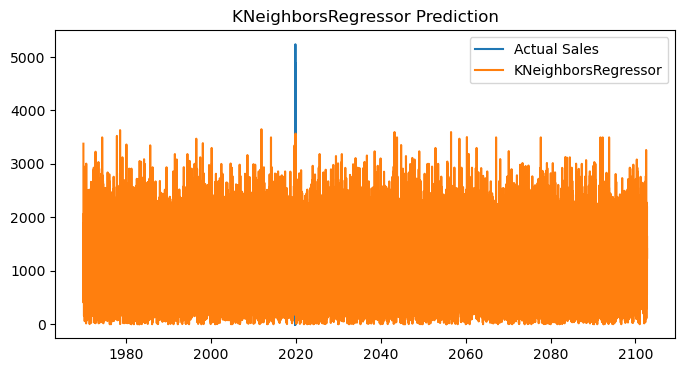

In [39]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(neigh_pred, label='KNeighborsRegressor')
plt.legend(loc='best')
plt.title('KNeighborsRegressor Prediction')
plt.show()

In [40]:
mse = mean_squared_error(y_test, neigh_pred )
msle = mean_squared_log_error(y_test, neigh_pred)
rmse = np.sqrt(mean_squared_error(y_test, neigh_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, neigh_pred)).round(5)

# model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
results = pd.DataFrame([['KNN', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,KNN,54425.139171,0.052048,233.29,0.22814


### RandomForestRegressor

In [41]:
from sklearn.ensemble import RandomForestRegressor
# Initialize and fit the Random Forest Regressor
forest = RandomForestRegressor()
model_forest = forest.fit(X_train, y_train)

# Make predictions on X_test
forest_pred = model_forest.predict(X_test)

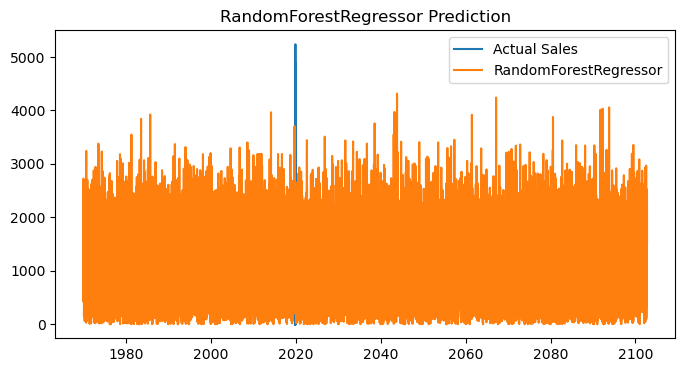

In [42]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual Sales')
plt.plot(forest_pred, label='RandomForestRegressor')
plt.legend(loc='best')
plt.title('RandomForestRegressor Prediction')
plt.show()

In [43]:
mse = mean_squared_error(y_test, forest_pred)
msle = mean_squared_log_error(y_test, forest_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

# Append the results to the DataFrame
model_results = pd.DataFrame([['Random Forest', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index=True)
results

,Model,MSE,MSLE,RMSE,RMSLE
0,KNN,54425.139171,0.052048,233.29,0.22814
1,Random Forest,25909.858560,0.028885,160.97,0.16996


### Gradient Boosting

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and fit the Gradient Boosting model
gbr = GradientBoostingRegressor()
model_gbr = gbr.fit(X_train, y_train)

# Make predictions on X_test
gbr_pred = model_gbr.predict(X_test)

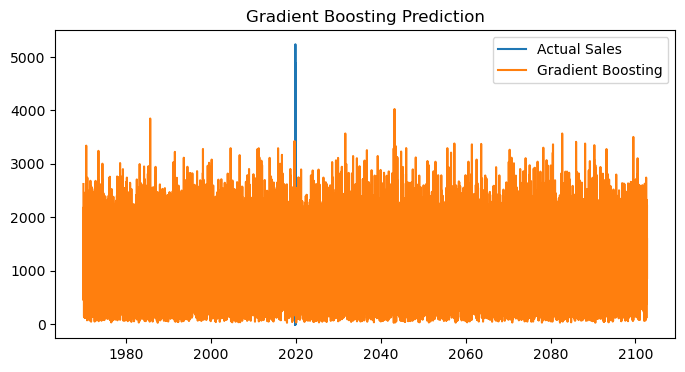

In [45]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual Sales')
plt.plot(gbr_pred, label='Gradient Boosting')
plt.legend(loc='best')
plt.title('Gradient Boosting Prediction')
plt.show()

In [46]:
# Append the results to the DataFrame
mse = mean_squared_error(y_test, gbr_pred)
# msle = mean_squared_log_error(y_test, gbr_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['Gradient Boosting', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index=True)

### Ridge regression

In [47]:
from sklearn.linear_model import Ridge

# Initialize and fit the Ridge model
ridge = Ridge(alpha=1.0)  # You can adjust the alpha parameter
model_ridge = ridge.fit(X_train, y_train)

# Make predictions on X_test using Ridge model
ridge_pred = model_ridge.predict(X_test)

# Calculate MSE and RMSE
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse).round(2)

# Append the results to the DataFrame
ridge_results = pd.DataFrame([['Ridge', ridge_mse, ridge_rmse]],
                             columns=['Model', 'MSE', 'RMSE'])

results = results.append(ridge_results, ignore_index=True)

### Lasso regression

In [48]:
from sklearn.linear_model import Lasso

# Initialize and fit the Lasso model
lasso = Lasso(alpha=1.0)  # You can adjust the alpha parameter
model_lasso = lasso.fit(X_train, y_train)

# Make predictions on X_test using Lasso model
lasso_pred = model_lasso.predict(X_test)

# Calculate MSE and RMSE
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_rmse = np.sqrt(lasso_mse).round(2)

# Append the results to the DataFrame
lasso_results = pd.DataFrame([['Lasso', lasso_mse, lasso_rmse]],
                             columns=['Model', 'MSE', 'RMSE'])

results = results.append(lasso_results, ignore_index=True)


### XGboost

In [49]:
import xgboost as xgb

# Initialize and fit the XGBoost model
xgboost = xgb.XGBRegressor()
model_xgboost = xgboost.fit(X_train, y_train)

# Make predictions on X_test
xgboost_pred = model_xgboost.predict(X_test)

# Append the results to the DataFrame
mse = mean_squared_error(y_test, xgboost_pred)
# msle = mean_squared_log_error(y_test, xgboost_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['XGBoost', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index=True)

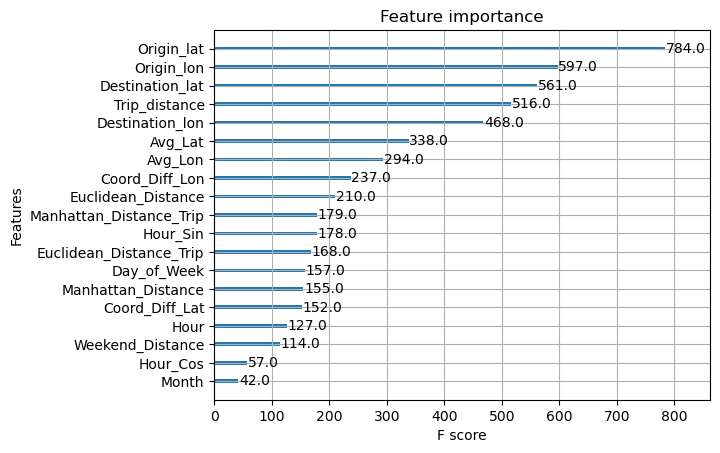

Origin_lat: 784.0
Origin_lon: 597.0
Destination_lat: 561.0
Trip_distance: 516.0
Destination_lon: 468.0
Avg_Lat: 338.0
Avg_Lon: 294.0
Coord_Diff_Lon: 237.0
Euclidean_Distance: 210.0
Manhattan_Distance_Trip: 179.0
Hour_Sin: 178.0
Euclidean_Distance_Trip: 168.0
Day_of_Week: 157.0
Manhattan_Distance: 155.0
Coord_Diff_Lat: 152.0
Hour: 127.0
Weekend_Distance: 114.0
Hour_Cos: 57.0
Month: 42.0


In [50]:
import matplotlib.pyplot as plt

# Using plot_importance function to visualize feature importance
xgb.plot_importance(model_xgboost)
plt.show()

# Alternatively, you can use the get_booster() method to get the booster object
booster = model_xgboost.get_booster()

# Get the feature importance scores
importance_scores = booster.get_score(importance_type='weight')

# Sort the importance scores in descending order
sorted_importance_scores = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

# Print the sorted importance scores
for feature, score in sorted_importance_scores:
    print(f"{feature}: {score}")

# Models Comparison

In [51]:
results

,Model,MSE,MSLE,RMSE,RMSLE
0,KNN,54425.139171,0.052048,233.29,0.22814
1,Random Forest,25909.858560,0.028885,160.97,0.16996
2,Gradient Boosting,36583.430213,0.028885,191.27,0.16996
3,Ridge,51390.882328,NaN,226.70,NaN
4,Lasso,54844.190092,NaN,234.19,NaN
5,XGBoost,23395.111622,0.028885,152.95,0.16996


# Model Evaluation (Backtests)

In [52]:
backtests = {
    1: ('2004-04-17', '2004-06-05'),
    2: ('2004-04-24', '2004-06-12'),
    3: ('2004-05-01', '2004-06-19')
}

In [53]:
# Backtests with KNN
scores = {}

for idx, period in enumerate(backtests):

    _train = train.reset_index()[train.reset_index()['date'] < backtests[period][0]]
    _test = train.reset_index()[(train.reset_index()['date'] >= backtests[period][0]) & (train.reset_index()['date'] <= backtests[period][1])]

    Xtrain, ytrain = _train.set_index(['date']).drop(columns=['target']), _train.target
    Xtest, ytest = _test.set_index(['date']).drop(columns=['target']), _test.target

    knn_model = KNeighborsRegressor(n_neighbors=1).fit(Xtrain, ytrain)

    ypred = knn_model.predict(Xtest)

    scores[period] = np.sqrt(mean_squared_error(ytest, ypred))

print(scores)

KeyError: "['target'] not found in axis"

# Hyperparameter Tuning

### predicting sales in our test

In [ ]:
test_pred = neigh.predict(test)
test_pred

In [ ]:
weekly_sum1['ETA'] = test_pred
sub = weekly_sum1[['ID', 'ETA']]
sub

In [ ]:
# Save sample submission
# sub.to_csv('submission.csv')

In [ ]:
# import pickle

# with open('encoder.pkl', 'wb') as f:
#     pickle.dump(encoder, f)

# with open('model.pkl', 'wb') as f:
#     pickle.dump(neigh, f)